# HyperParameter Testing

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
import wrds
import sys
sys.path.append('..')
import os

# Import Main Python Modules
from src.dataframe_construction import *
from src.a_estimation import *
from src.optimal_strategies import *
from src.backtest import *


### Backtesting

#### Setting up the data

In [2]:
daily = False
datapath='../data/'

if daily:
    d = 3000
    start_date='2013-01-01'
    filename='CRSP_2013_2018_daily_cleaned.h5'
    caps_table='dlyprevcap'
    returns_table='dlyret'
else:
    d = 2000
    start_date='1965-01-01'
    filename='CRSP_monthly_cleaned.h5'
    caps_table='mthprevcap'
    returns_table='mthret'

df = Data(d=d, start_date=start_date, datapath=datapath, filename=filename, caps_table=caps_table, returns_table=returns_table)

#### HyperParameter Testing

In [3]:
def plot_given_N(Ns, vector, m, folder, name):
    # Filter Ns and vector based on the m parameter
    Ns_filtered = [n for n in Ns if n <= m]
    vector_filtered = vector[:len(Ns_filtered)]

    plt.figure(figsize=(10, 5))
    plt.plot(Ns_filtered, vector_filtered, marker='o', linestyle='-', linewidth=2)
    plt.xlabel('N')
    plt.ylabel('Average Return')
    plt.title('Average Return for Different Ns')

    plt.savefig(f'{folder}{name}.png', dpi=300)

/home/pedro/Downloads/mathematical_finance/2-notebooks/../src/backtest.py:40: RuntimeWarning: overflow encountered in double_scalars
  cumulative_ret *= ret
/home/pedro/Downloads/mathematical_finance/2-notebooks/../src/backtest.py:40: RuntimeWarning: overflow encountered in double_scalars
  cumulative_ret *= ret
/home/pedro/Downloads/mathematical_finance/2-notebooks/../src/backtest.py:40: RuntimeWarning: overflow encountered in double_scalars
  cumulative_ret *= ret
/home/pedro/Downloads/mathematical_finance/2-notebooks/../src/backtest.py:40: RuntimeWarning: overflow encountered in double_scalars
  cumulative_ret *= ret
/home/pedro/Downloads/mathematical_finance/2-notebooks/../src/backtest.py:40: RuntimeWarning: overflow encountered in double_scalars
  cumulative_ret *= ret
/home/pedro/Downloads/mathematical_finance/2-notebooks/../src/backtest.py:40: RuntimeWarning: overflow encountered in double_scalars
  cumulative_ret *= ret
/home/pedro/Downloads/mathematical_finance/2-notebooks/../

KeyboardInterrupt: 

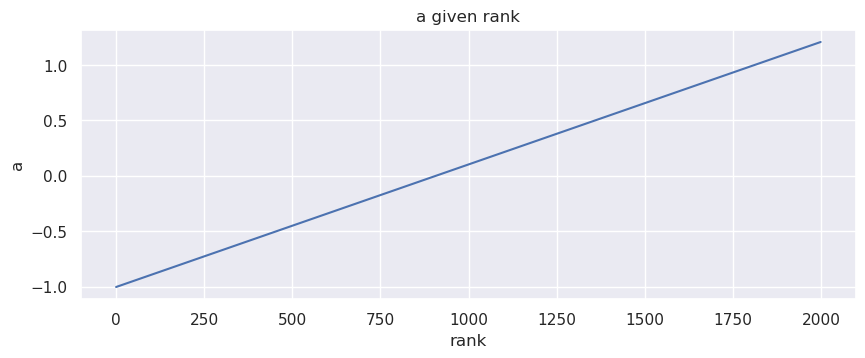

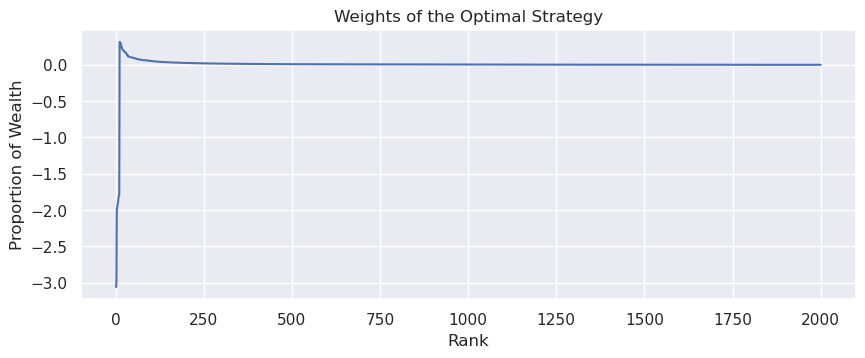

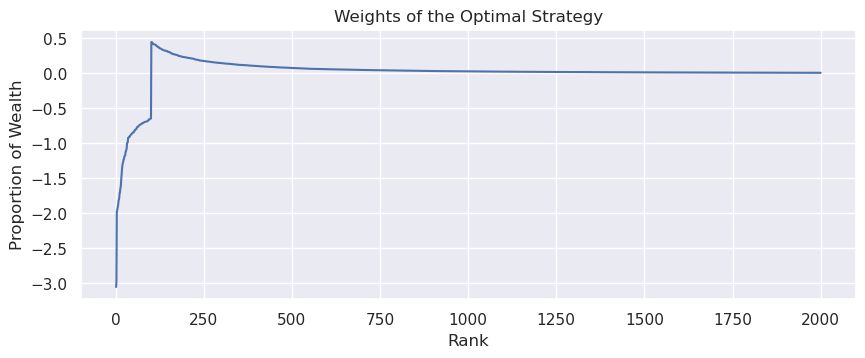

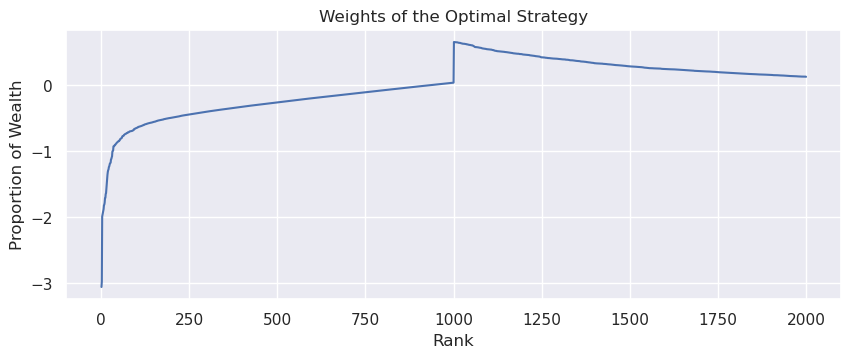

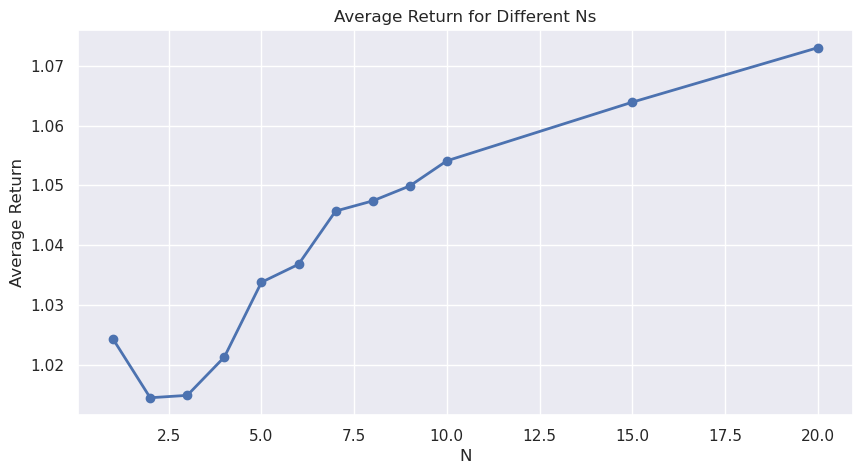

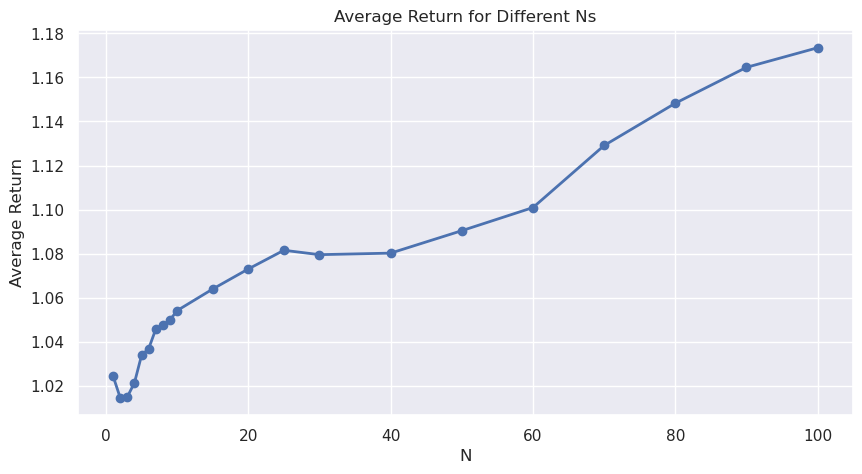

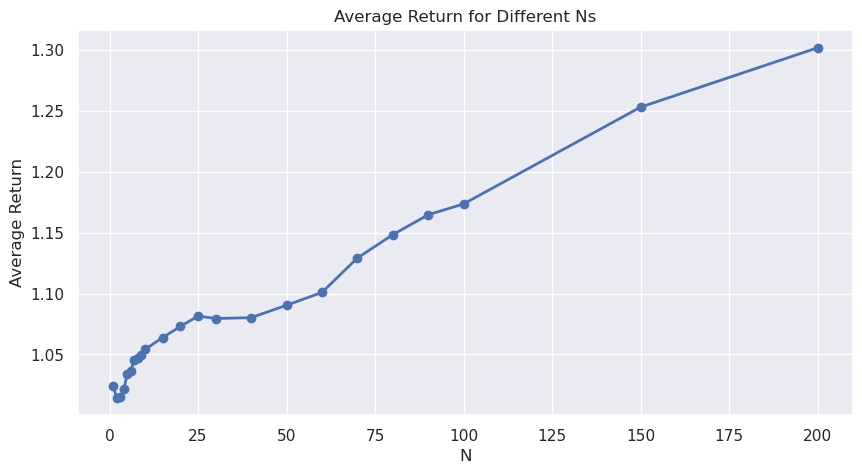

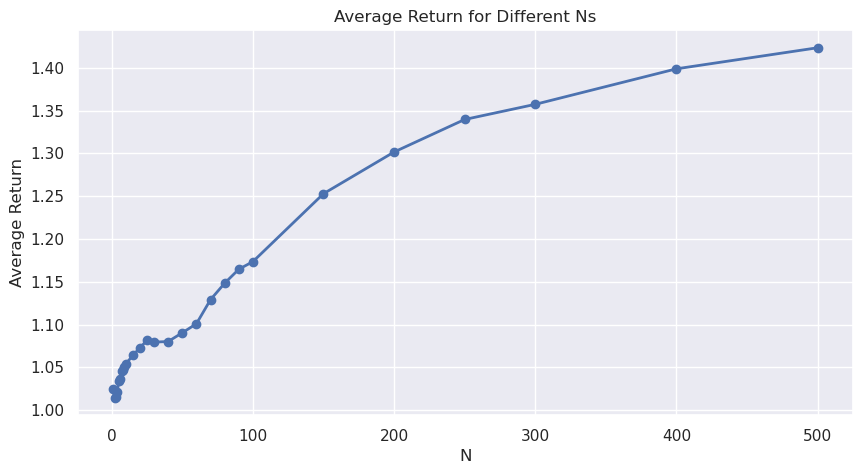

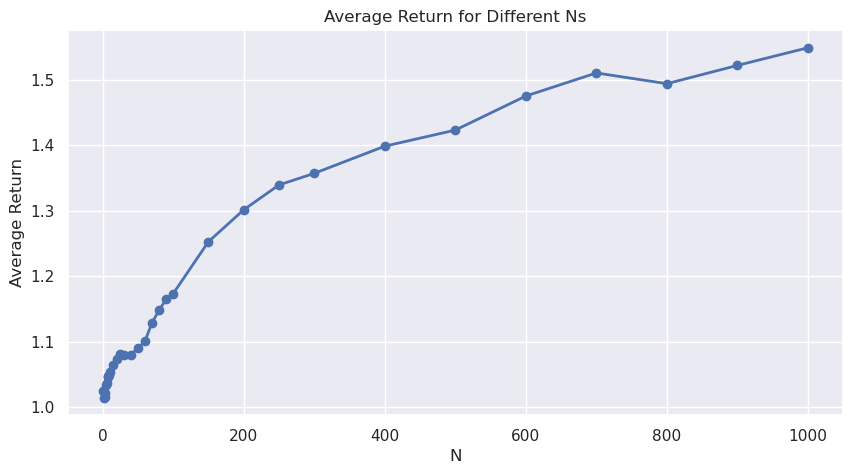

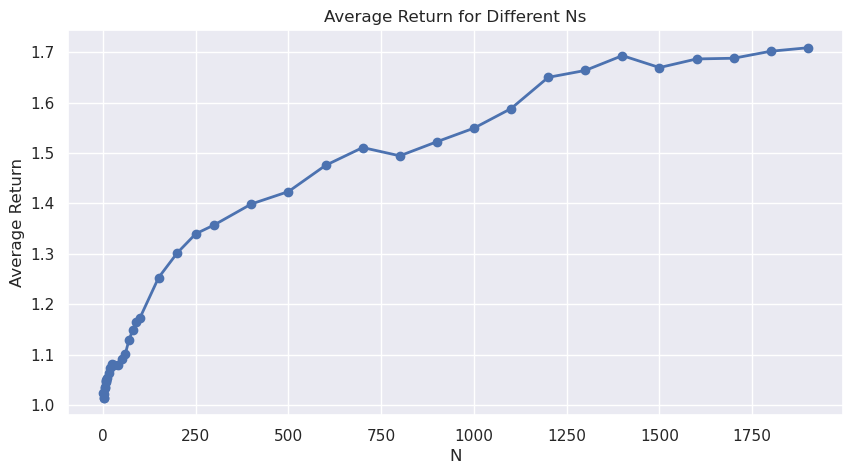

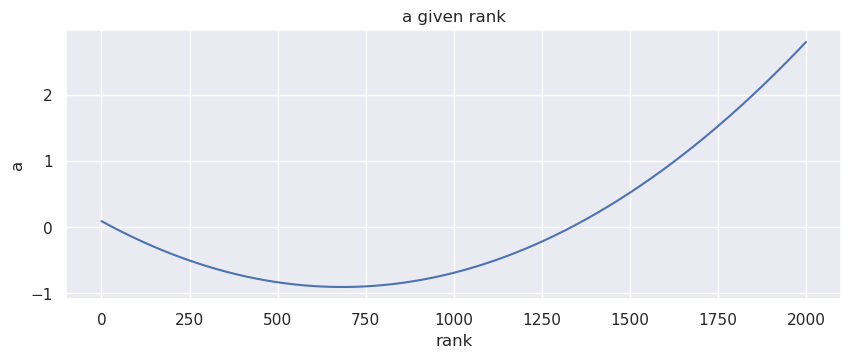

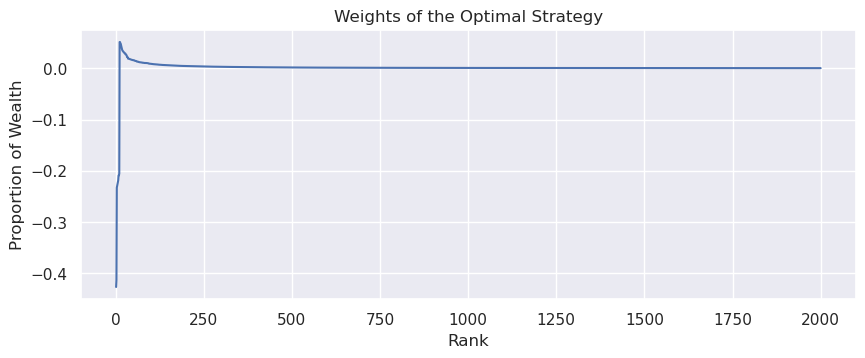

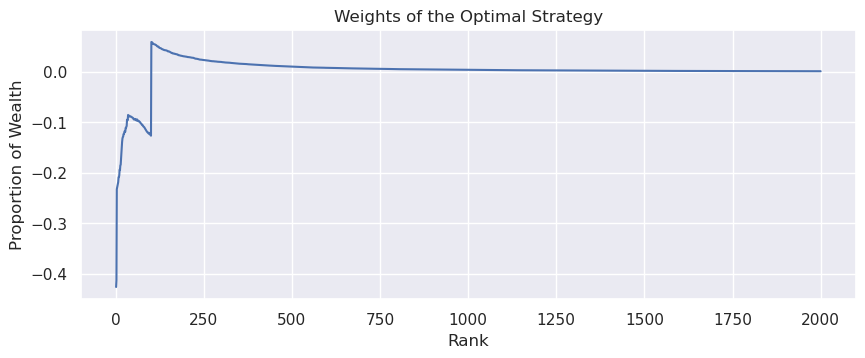

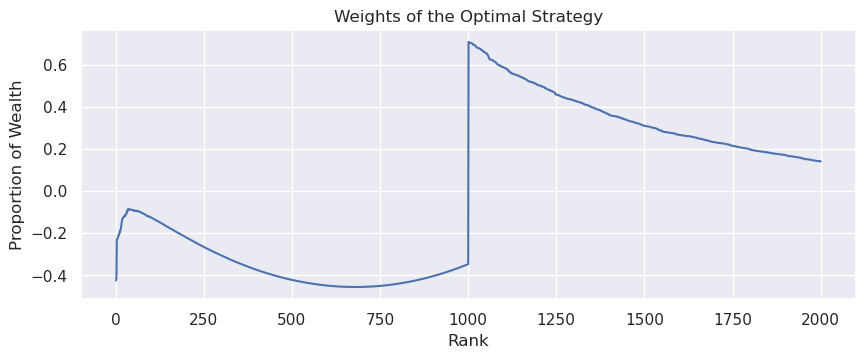

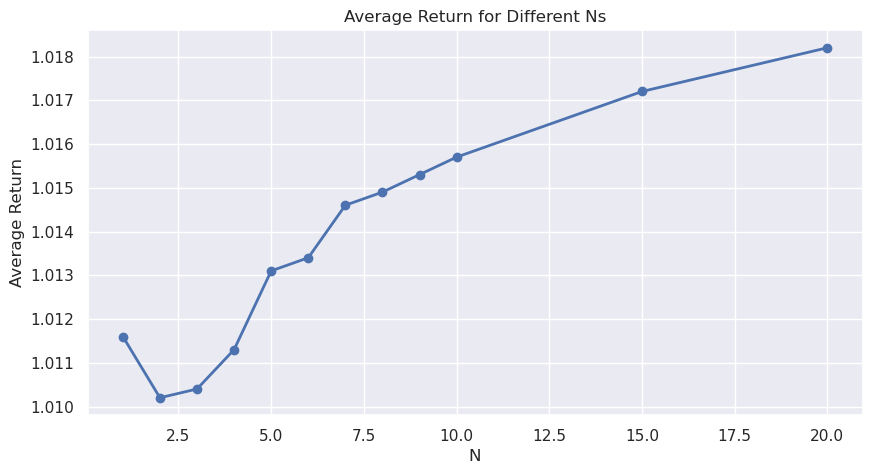

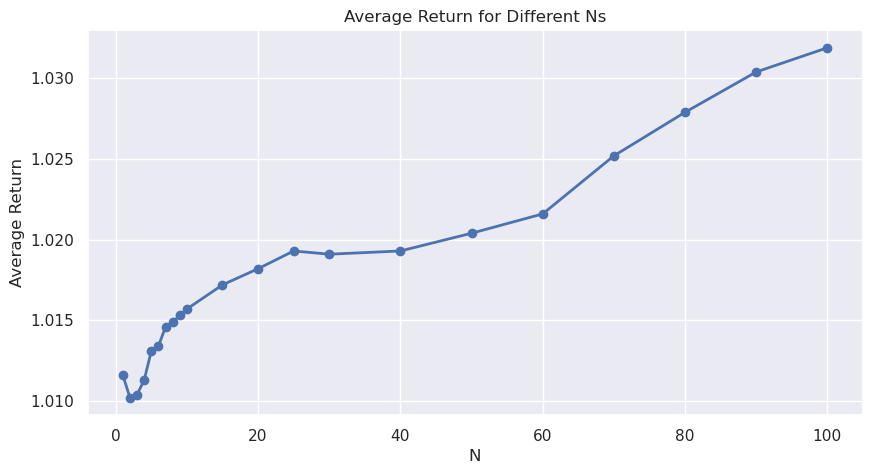

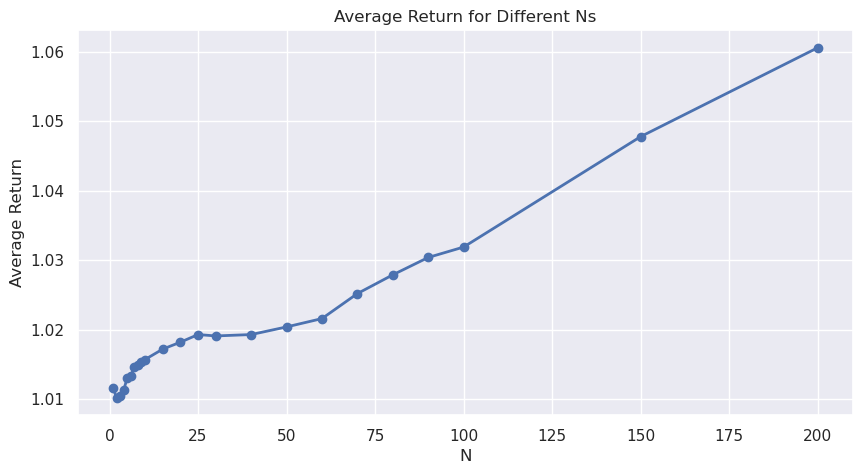

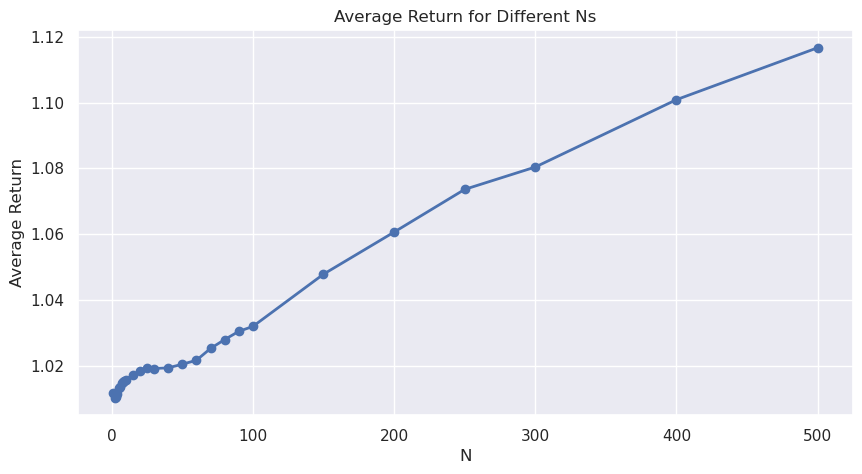

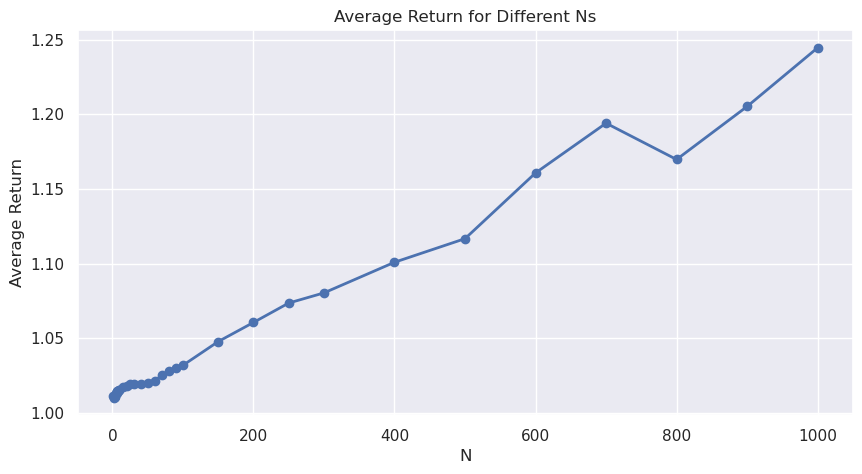

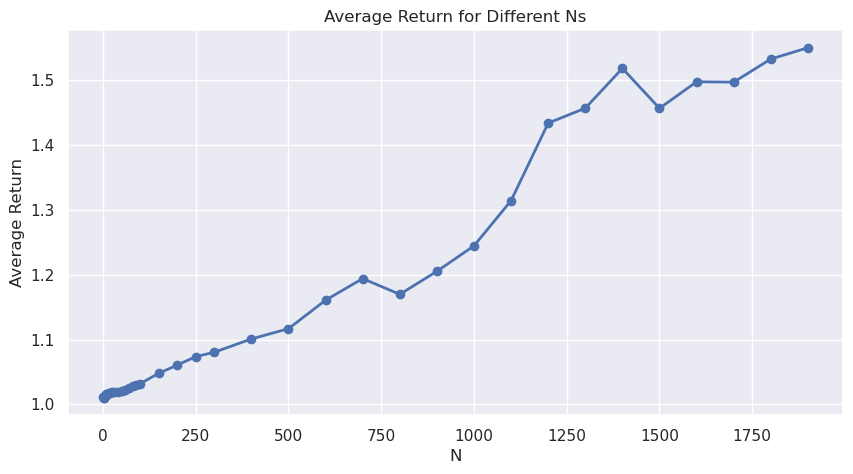

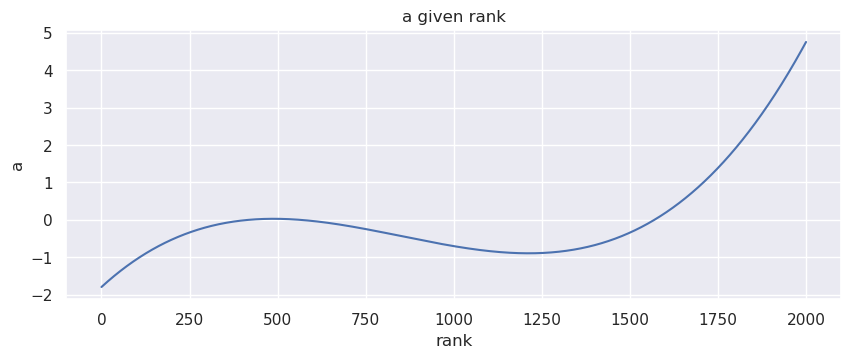

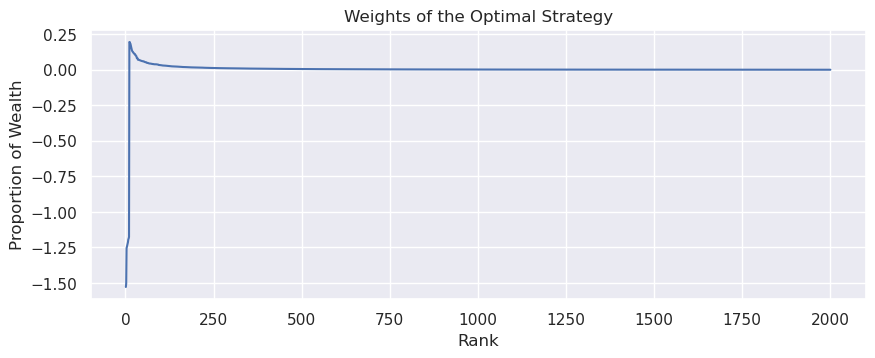

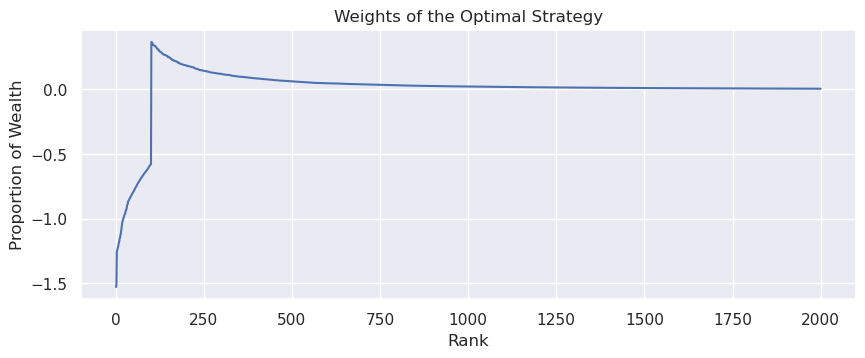

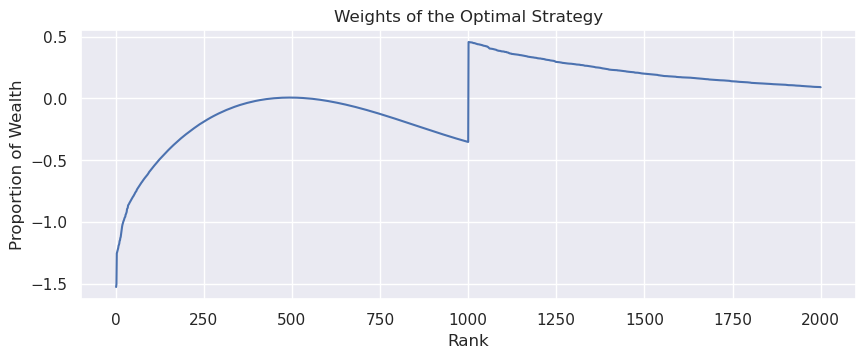

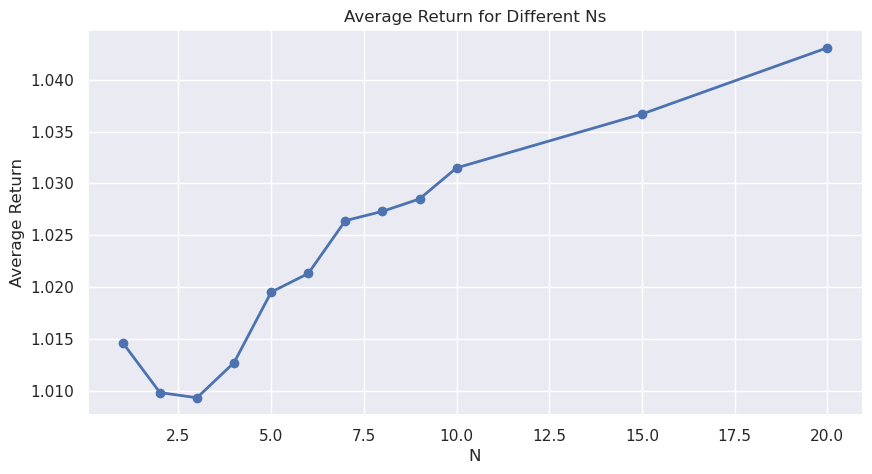

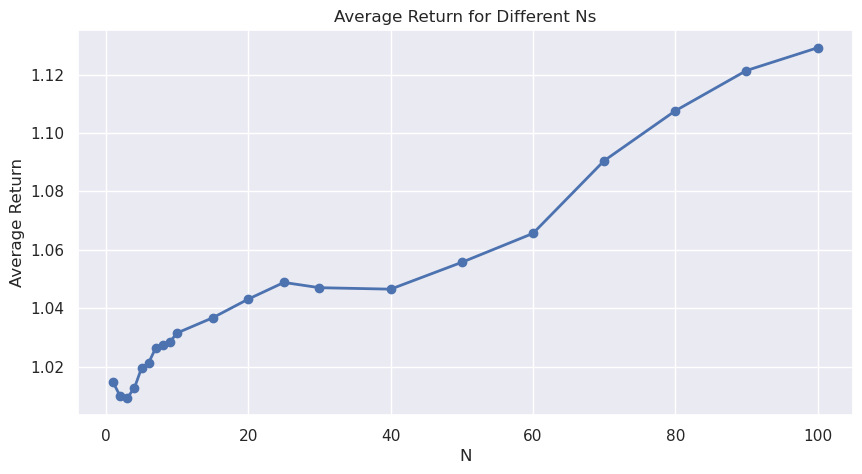

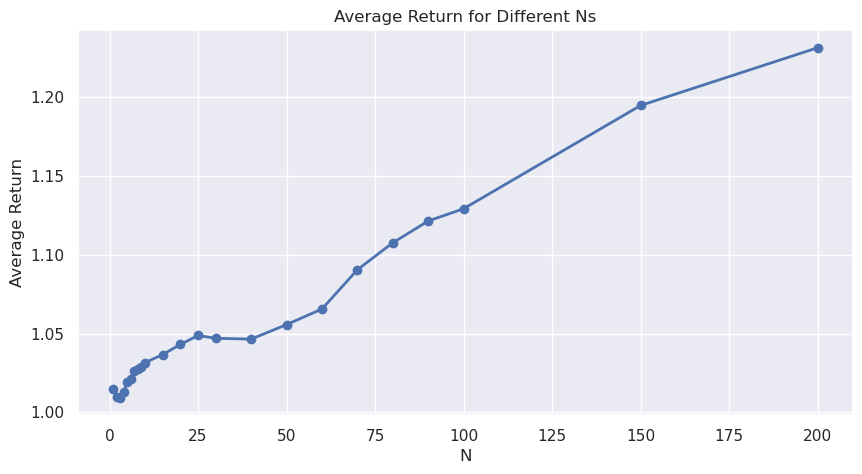

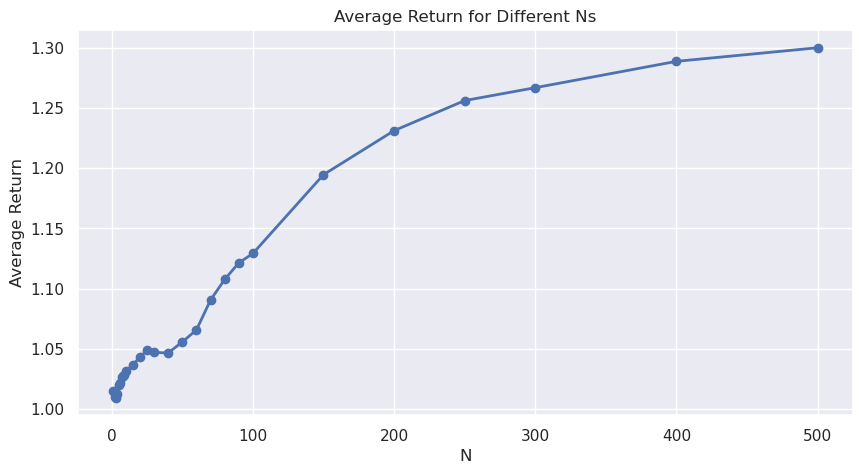

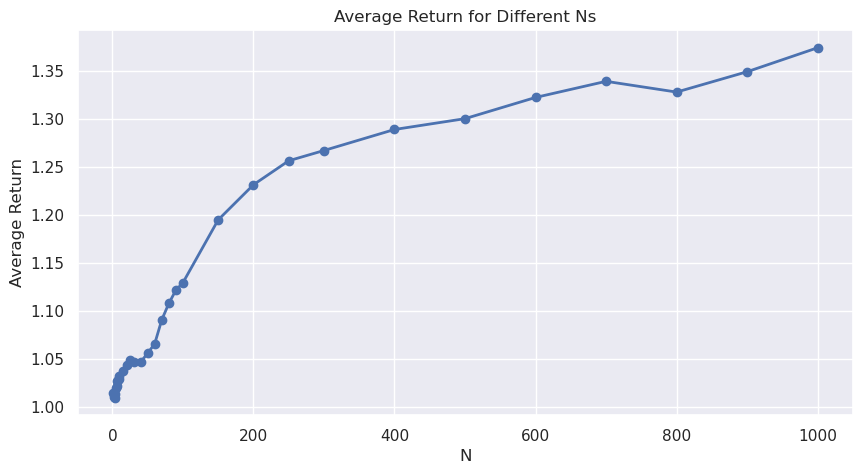

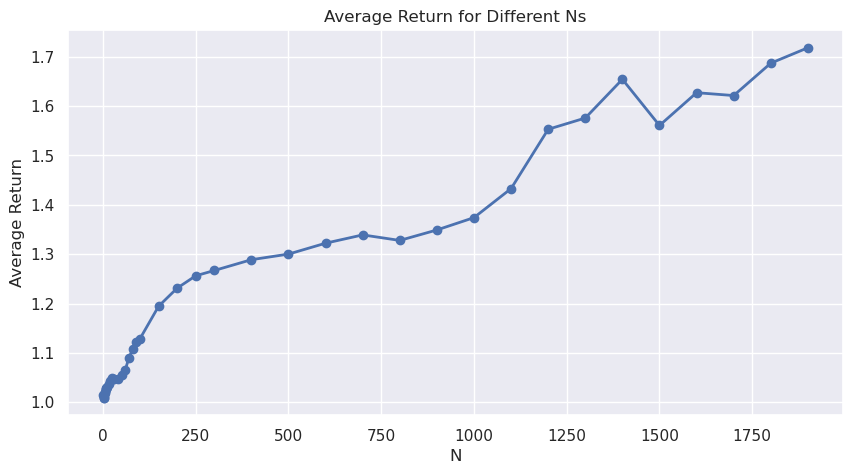

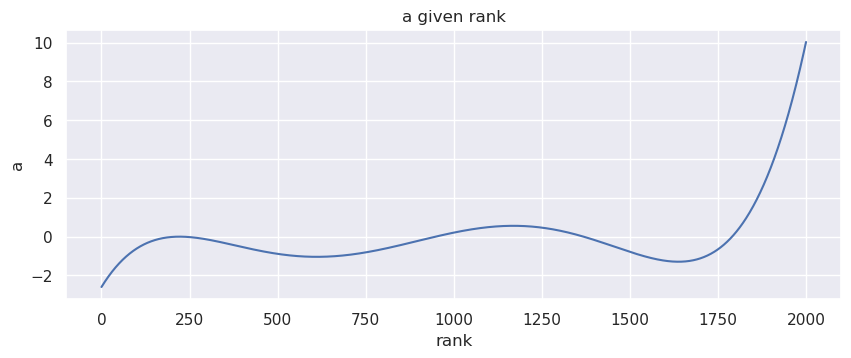

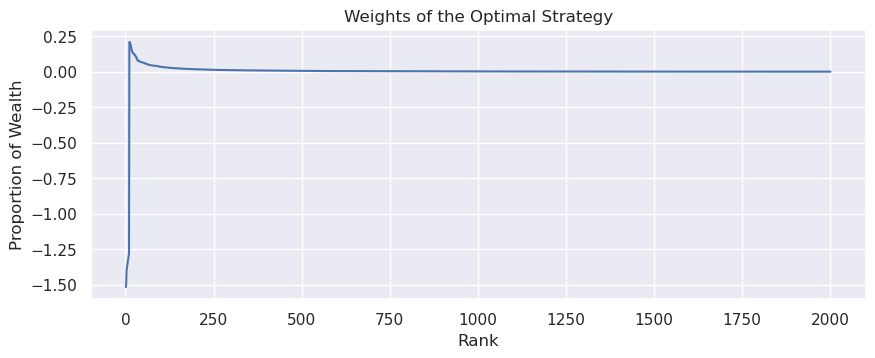

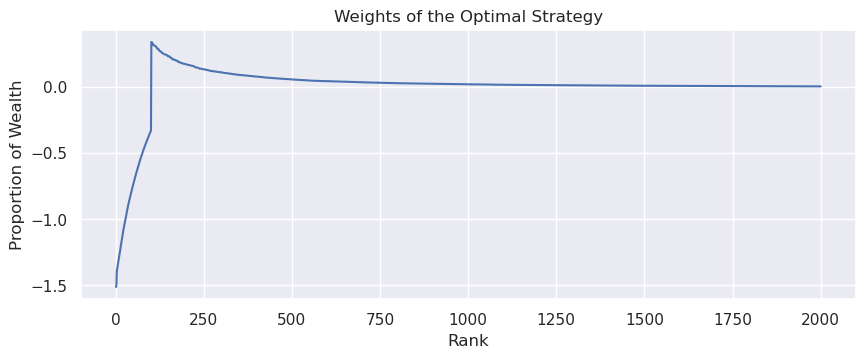

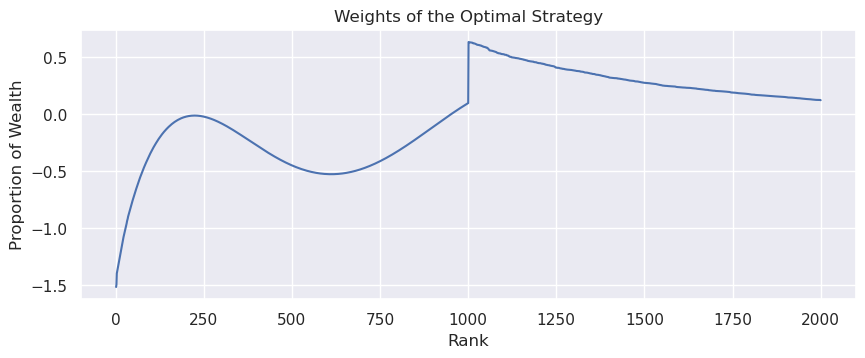

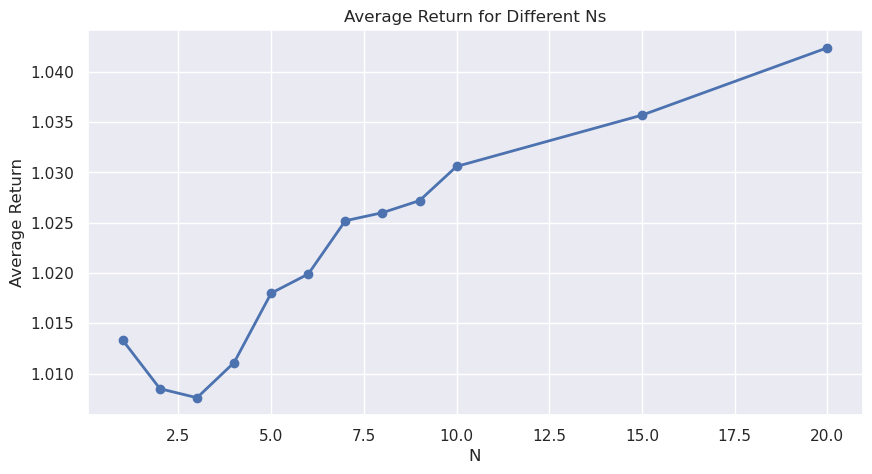

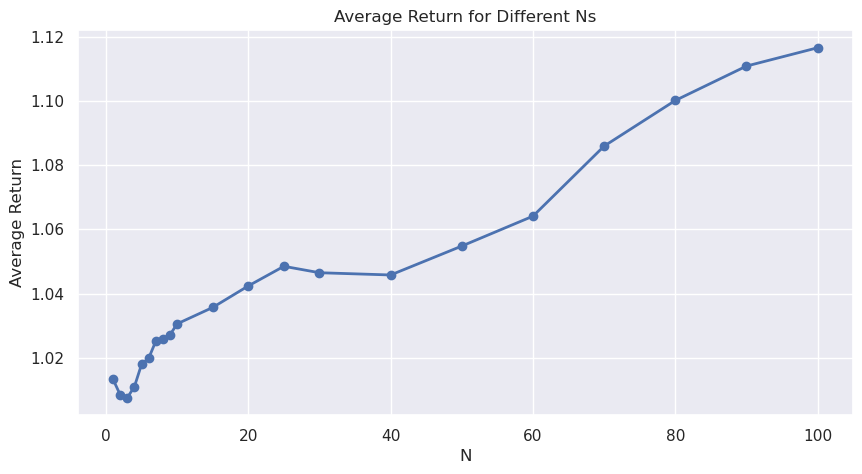

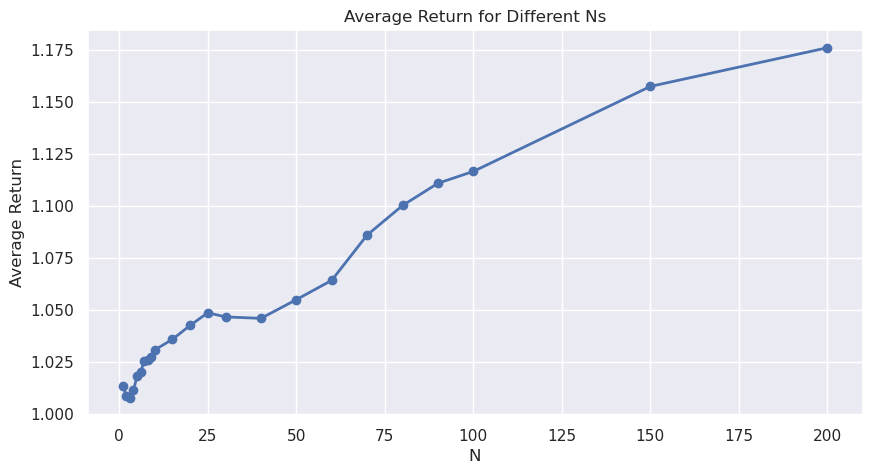

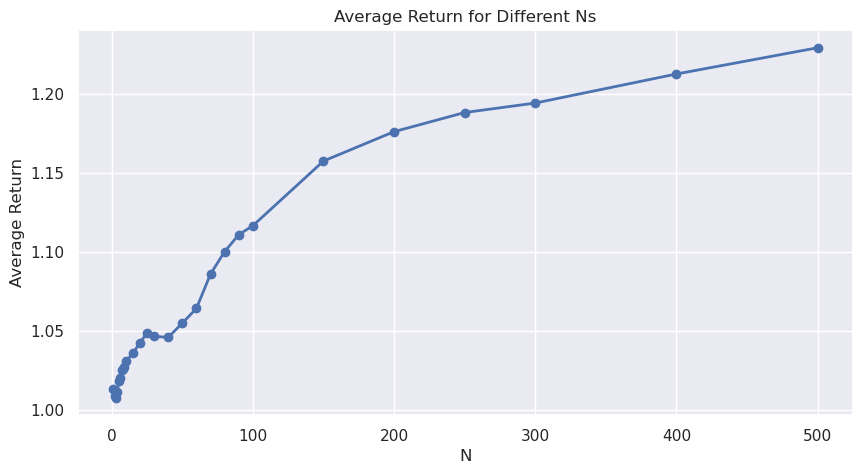

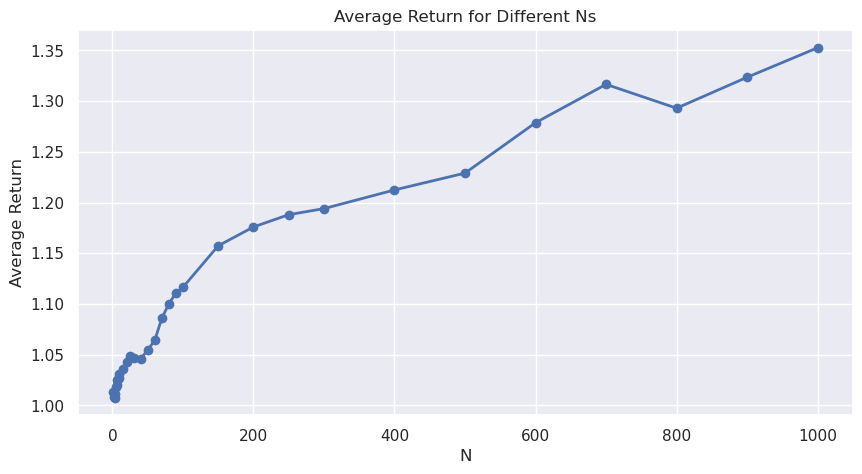

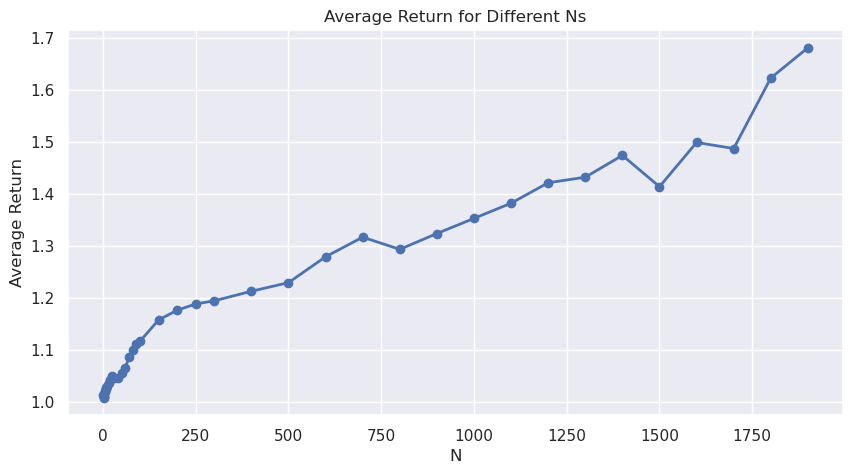

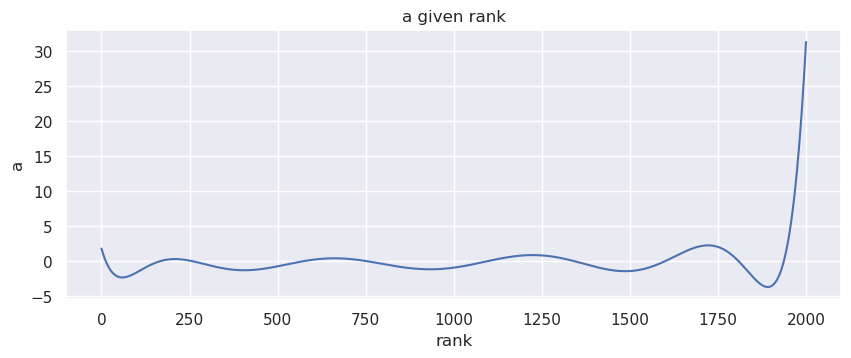

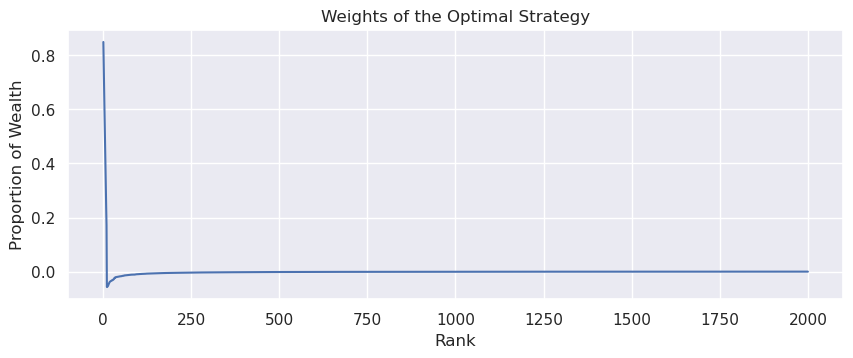

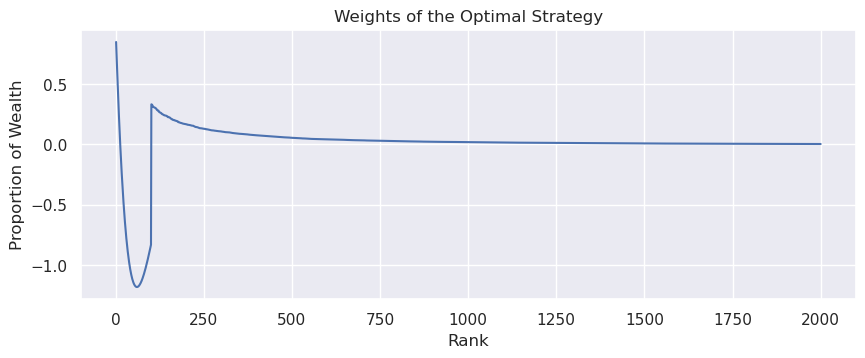

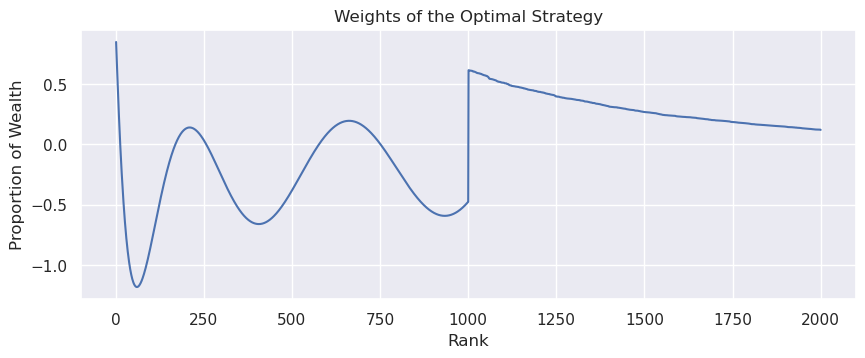

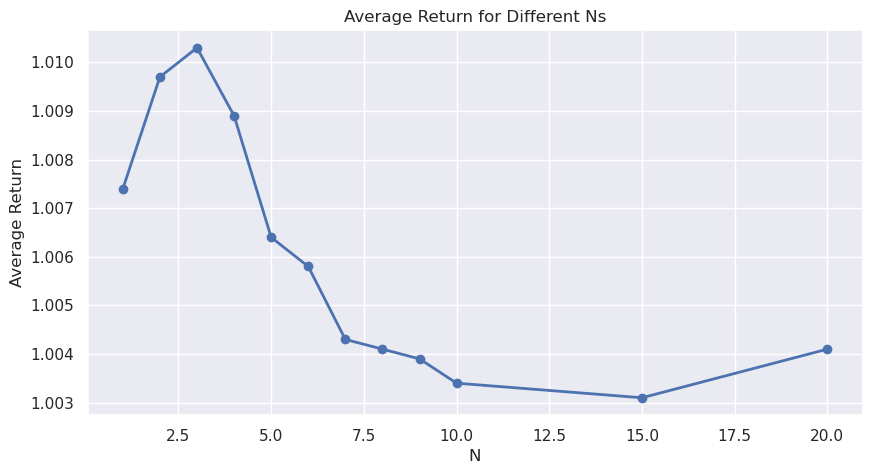

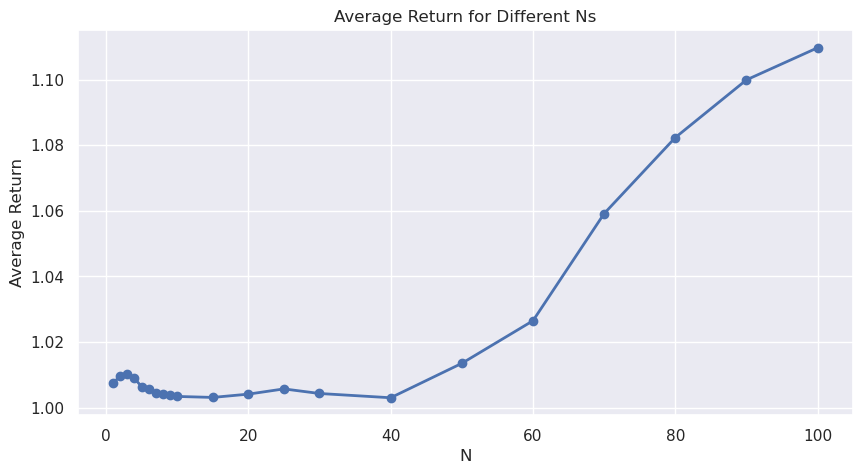

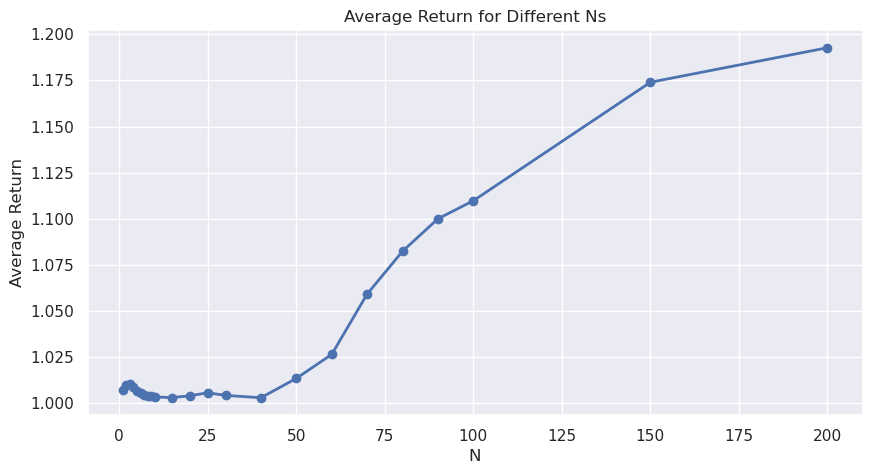

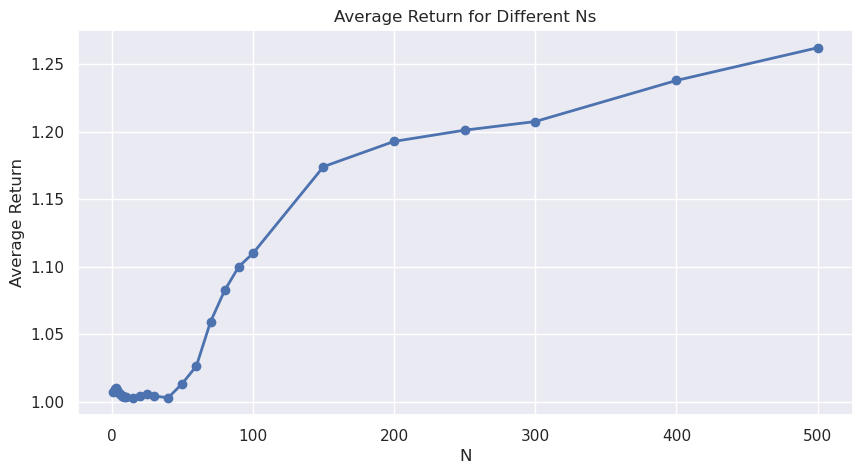

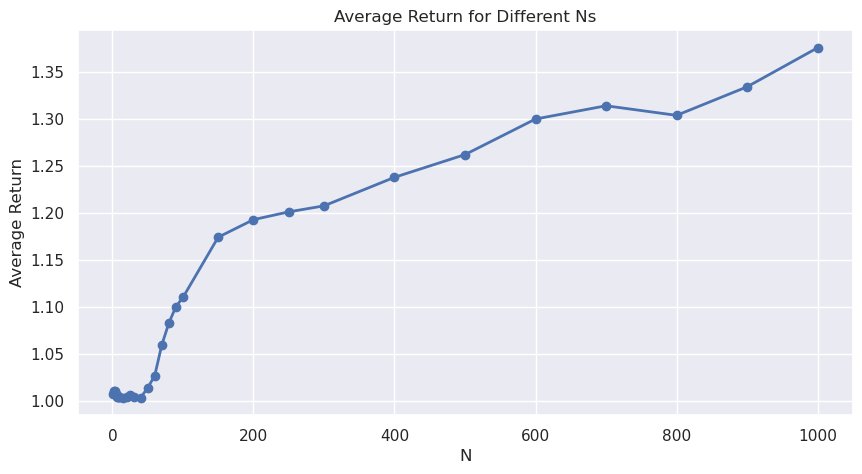

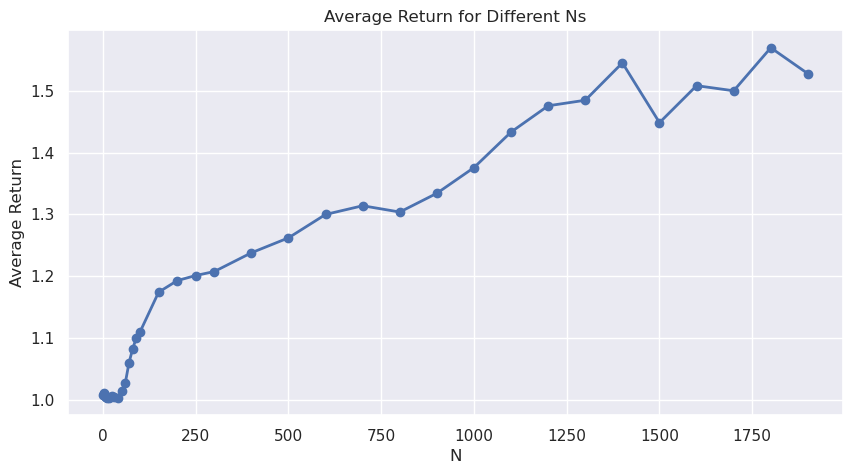

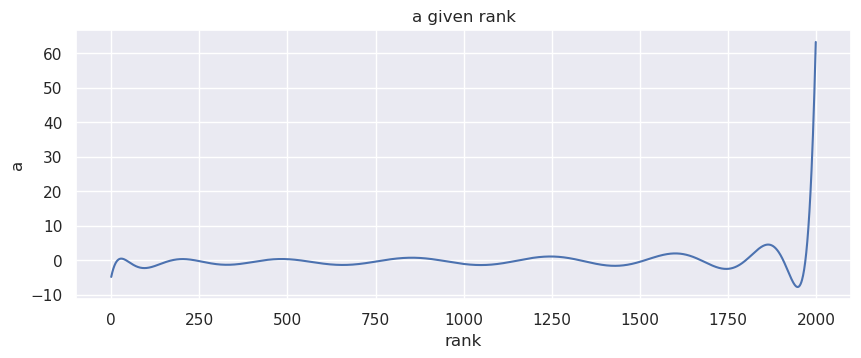

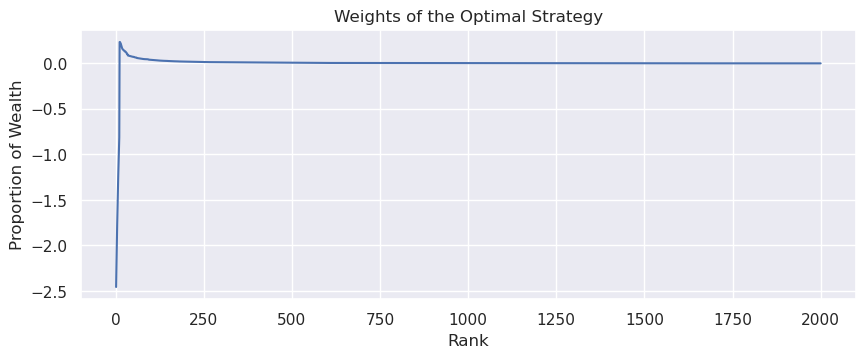

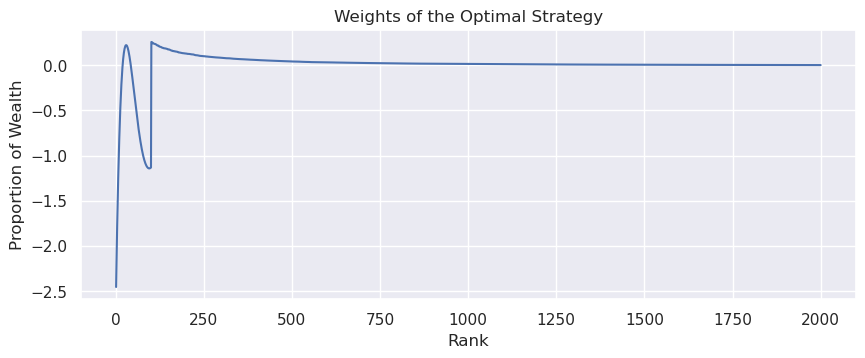

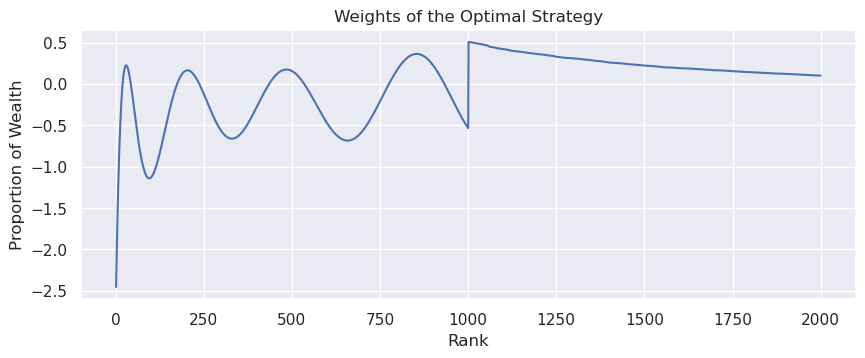

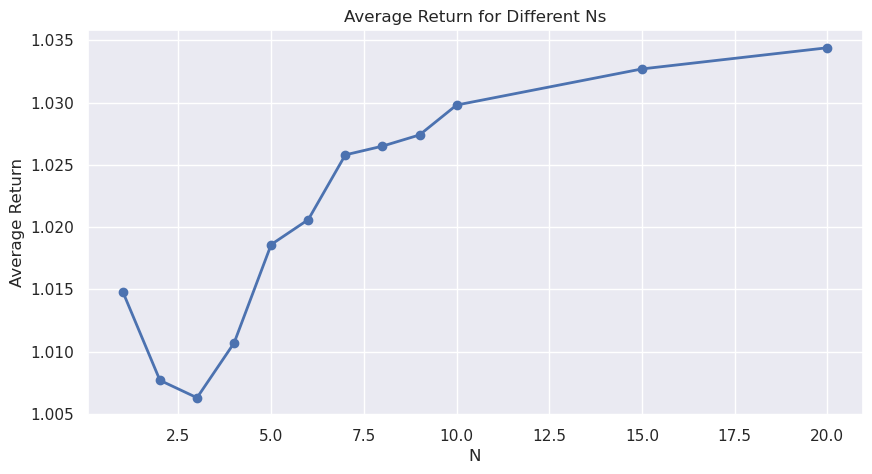

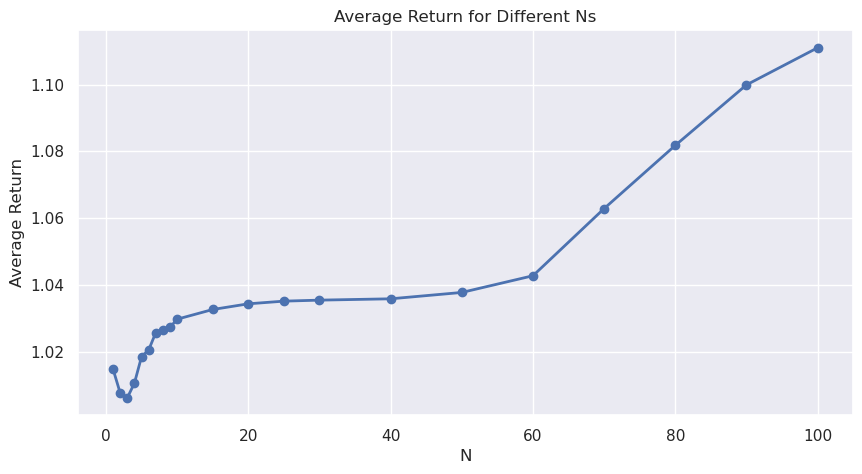

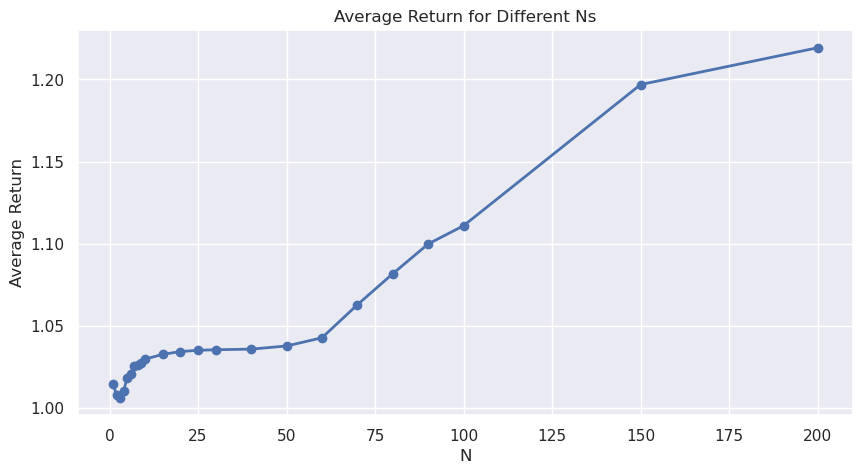

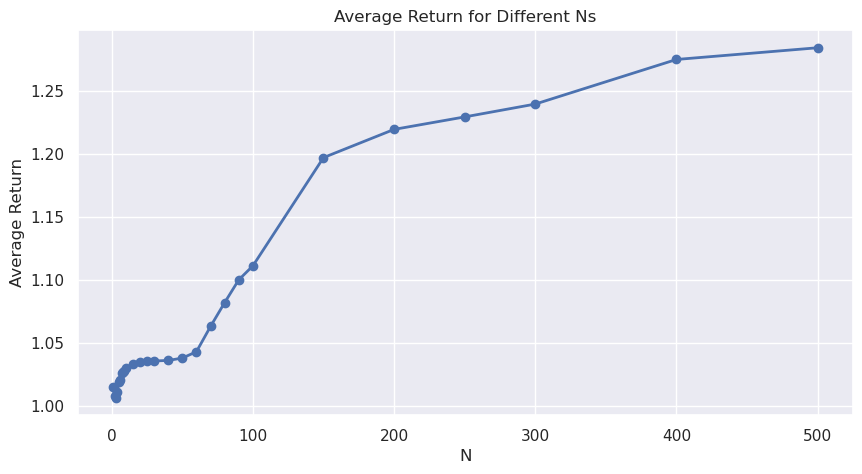

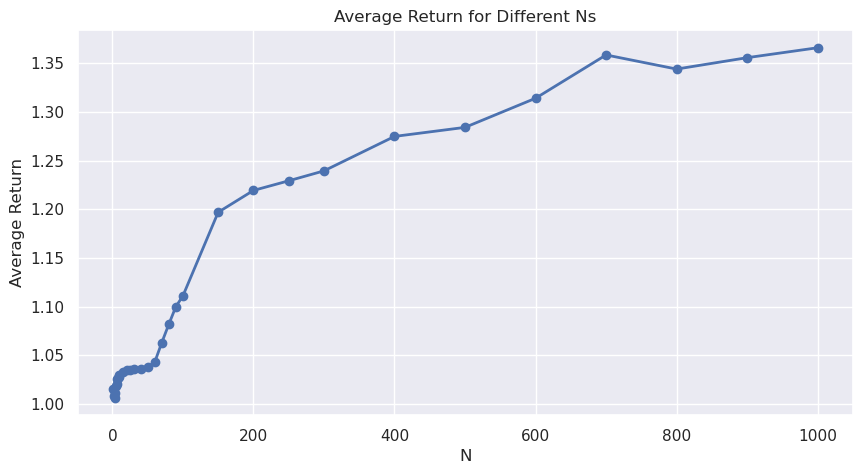

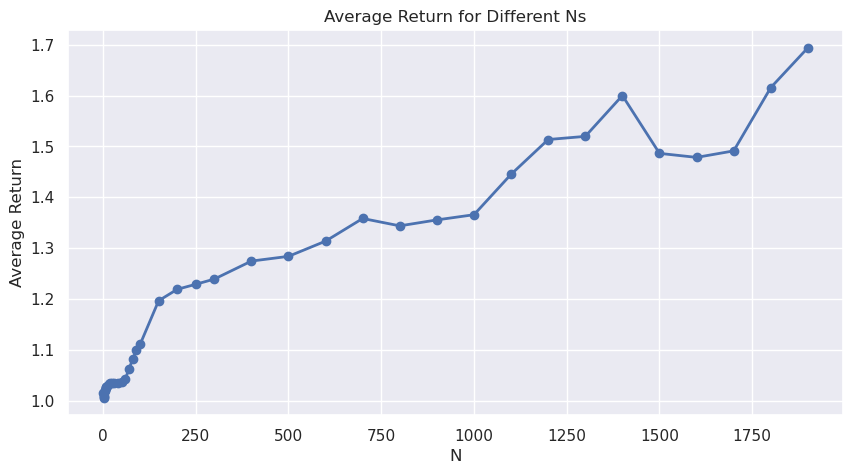

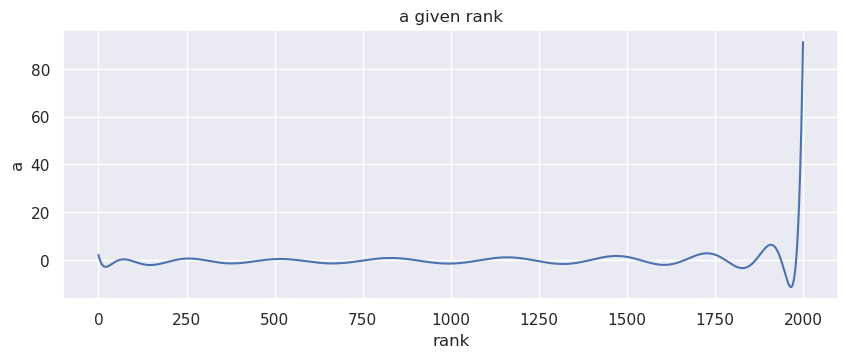

In [6]:
method = 'direct_log'
smooth_method = 'exponential_decay'
smooth_a = False
initial_folder_path = '../3-results/1-varying_smoothness/'
plot_date = '2013-03-28'

settings = ['pure', 'mixed']
smooth_parameters_pure = [1]#list(range(1, 16))
smooth_parameters_mixed = [1]#[1, 2, 3, 5, 10, 15, 20, 30, 50]
Ns = list(range(1, 10)) + list(range(10, 30, 5)) + list(range(30, 100, 10)) + list(range(100,300, 50)) + list(range(300,2000, 100))
interests_plots_up_to = [20, 100, 200, 500, 1000, 2000]
strategy_plots_N = [10, 100, 1000]

for setting in settings:
    folder_path = initial_folder_path + setting + '/'
    if setting == 'pure':
        smooth_parameters = smooth_parameters_pure
    else:
        smooth_parameters = smooth_parameters_mixed

    for smooth_parameter in smooth_parameters:
        average_returns = []
        final_cumulative_returns = []
        
        new_folder = folder_path + 'exponential_decay/'#'smoothness='+str(smooth_parameter)+'/'
        os.makedirs(new_folder, exist_ok=True)

        a = estimate_a(df.weights_by_rank, smooth_method=smooth_method, smooth_parameter=smooth_parameter,  smooth_a=smooth_a)
        plot_a(a, data_path=new_folder + 'a_plot')

        for N in Ns:
            strategy = compute_weights_optimal_open(setting=setting, N=N, a=a, weights_by_rank=df.weights_by_rank)
            if N in strategy_plots_N:
                plot_strategy(strategy=strategy, date=plot_date, data_path=new_folder+'strategy_plot_N='+str(N))
            backtest = Backtest(strategy=strategy, weights_permno_by_rank=df.weights_permno_by_rank, returns_by_permno=df.returns_by_permno)
            backtest.run()

            average_return = round(np.mean(backtest.rets), 4)
            final_cumulative_return = round(backtest.cumulative_rets[-1], 4)

            average_returns.append(average_return)
            final_cumulative_returns.append(final_cumulative_return)
            # print('N =', N, '. Average return:', average_return, '; Final Cumulative Return:', final_cumulative_return)

        for first_print in interests_plots_up_to:
            plot_given_N(Ns, average_returns, first_print, new_folder, 'average_returns_'+str(first_print))